# Experience on an irregularly sampled ring graph

In [1]:
%matplotlib inline

import numpy as np
from scipy import spatial
from matplotlib import pyplot as plt
import pygsp as pg

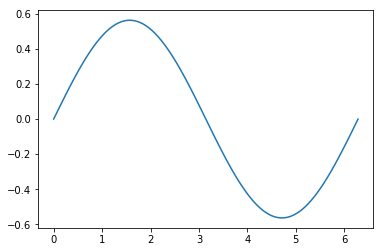

In [2]:
xx = np.linspace(0,2*np.pi,100)
yy = np.sin(xx)/np.sqrt(np.pi)
coordX = np.cos(xx)
coordY = np.sin(xx)
plt.plot(xx, yy)

In [14]:
def plot(graphs, position, n_vertices):
    
    fig1, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Plot one eigenvector (Fourier mode) on a 2D embedding.
    for graph, ax in zip(graphs, axes[0]):
        graph.compute_fourier_basis()
        graph.plot(graph.U[:, 1], ax=ax)

    # Plot multiple eigenvectors (Fourier modes) on a 1D embedding.
    graphs[0].set_coordinates('line1D')
    graphs[0].plot(graphs[0].U[:, :5], ax=axes[1, 0])
    graph.set_coordinates(position)
    graphs[1].plot(graphs[1].U[:, :5], ax=axes[1, 1])

    fig2, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Both graphs have the same connectivity pattern / sparsity structure.
    for graph, ax in zip(graphs, axes[0]):
        ax.spy(graph.W)

    # They however have different edge weights.
    for graph, ax in zip(graphs, axes[1]):
        ax.hist(graph.W.data)

    return fig1, fig2

## Sparse graphs built from geodesic distances

In [15]:
graphs[1].W

<20x20 sparse matrix of type '<class 'numpy.float64'>'
	with 380 stored elements in Compressed Sparse Row format>

  (0, 0)	2.0
  (0, 1)	-1.0
  (0, 10)	-1.0
  (1, 0)	-1.0
  (1, 1)	2.0
  (1, 2)	-1.0
  (2, 1)	-1.0
  (2, 2)	2.0
  (2, 3)	-1.0
  (3, 2)	-1.0
  (3, 3)	2.0
  (3, 4)	-1.0
  (4, 3)	-1.0
  (4, 4)	2.0
  (4, 5)	-1.0
  (5, 4)	-1.0
  (5, 5)	2.0
  (5, 6)	-1.0
  (6, 5)	-1.0
  (6, 6)	2.0
  (6, 7)	-1.0
  (7, 6)	-1.0
  (7, 7)	2.0
  (7, 8)	-1.0
  (8, 7)	-1.0
  (8, 8)	2.0
  (8, 9)	-1.0
  (9, 8)	-1.0
  (9, 9)	2.0
  (9, 10)	-1.0
  (10, 0)	-1.0
  (10, 9)	-1.0
  (10, 10)	2.0


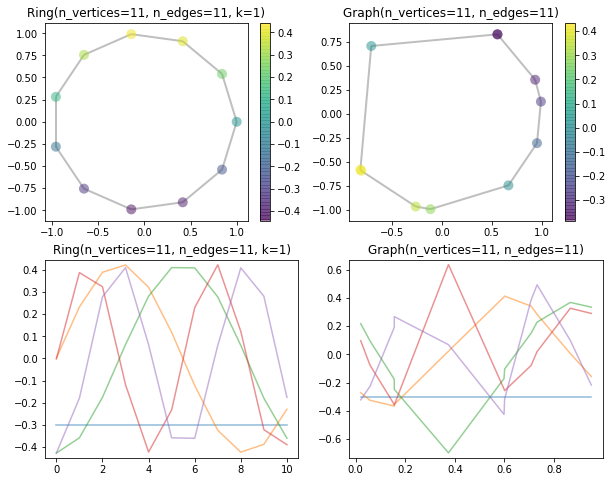

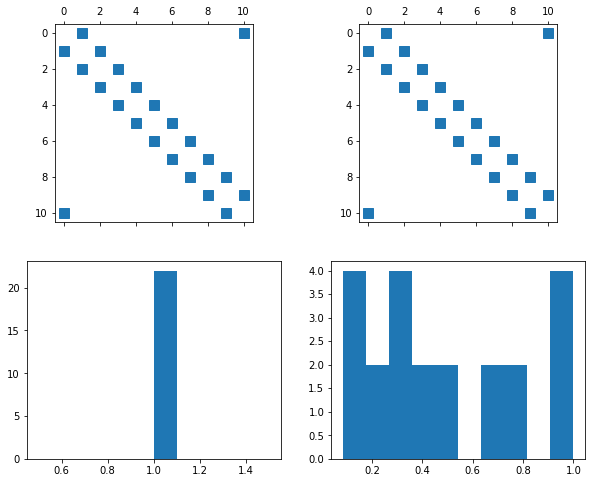

In [27]:
n_vertices = 11
seed = 42

graphs = [
    pg.graphs.Ring(n_vertices),
    pg.graphs.RandomRing(n_vertices, seed=seed),
]

# Angular position of nodes in [0, 1].
position = np.sort(np.random.RandomState(seed).uniform(size=n_vertices), axis=0)

# Fix bug in pygsp: use similarity not distance.
width = np.mean(graphs[1].W.data)
graphs[1].W.data = np.exp(-graphs[1].W.data / width)
graphs[1] = pg.graphs.Graph(graphs[1].W, coords=graphs[1].coords)

fig, _ = plot(graphs, position, n_vertices)
fig.savefig('eigenvectors_sparse_geodesic.png')
print(graphs[0].L)

## Full graphs built from Euclidean distances

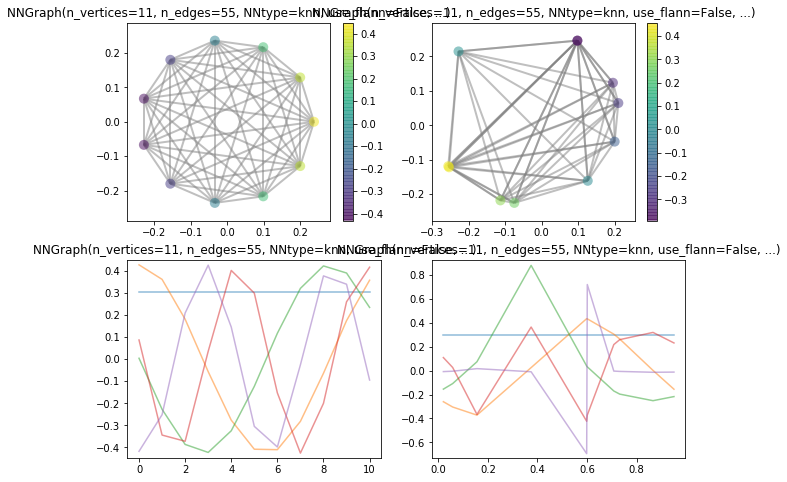

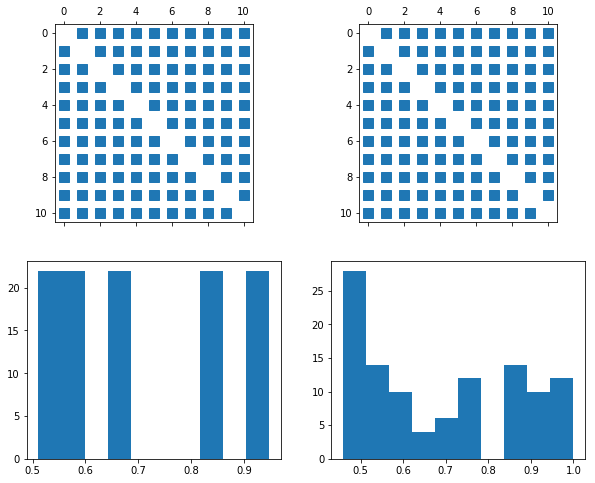

In [23]:
graphs = [
    pg.graphs.NNGraph(pg.graphs.Ring(n_vertices).coords, k=n_vertices-1),
    pg.graphs.NNGraph(pg.graphs.RandomRing(n_vertices, seed=seed).coords, k=n_vertices-1),
]

fig, _ = plot(graphs, position, n_vertices)
fig.savefig('eigenvectors_full_euclidean.png')

## Full graphs built from geodesic distances

Doesn't seem to be the right solution as it gives the wrong eigenvectors even for the regular ring graph.

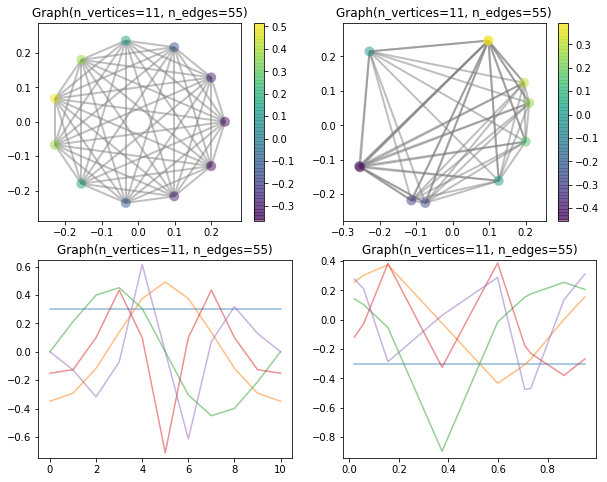

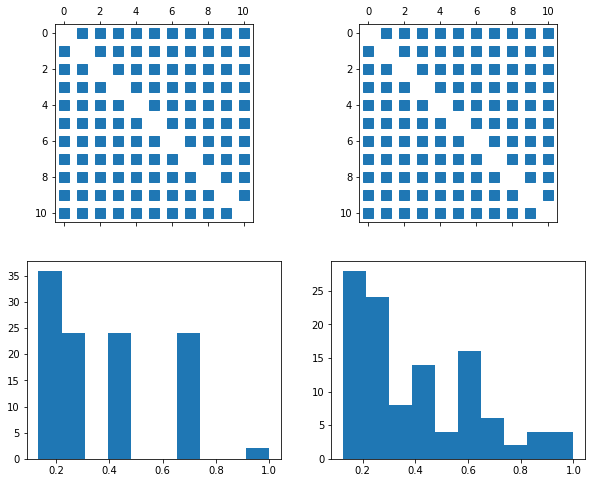

In [31]:
graphs = [
    pg.graphs.NNGraph(pg.graphs.Ring(n_vertices).coords),
    pg.graphs.NNGraph(pg.graphs.RandomRing(n_vertices, seed=seed).coords),
]

def build_full_geodesic_ring(position, coords):
    distances = spatial.distance.pdist(position[:, np.newaxis])
    distances = spatial.distance.squareform(distances)
    distances = np.minimum(distances, 1-distances)  # periodic distance
    weights = np.exp(-distances / np.mean(distances))
    weights -= np.diag(weights.diagonal())
    return pg.graphs.Graph(weights, coords=coords)

graphs[0] = build_full_geodesic_ring(np.linspace(0, 1, n_vertices), graphs[0].coords)
graphs[1] = build_full_geodesic_ring(position, graphs[1].coords)

fig, _ = plot(graphs, position, n_vertices)
fig.savefig('eigenvectors_full_geodesic.png')

In [ ]:
Gr